In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import random

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-06-17 10:11:15.098912: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750135275.110287  150763 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750135275.113250  150763 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 10:11:15.123971: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Normalized features

In [2]:


# Define the path to your dataset
dataset_path = "/home/muzaffar/Desktop/Research/papers/02-paperhybrid-word-spken-paper(ablation)/10-words/original-data-3630"

# Initialize lists to hold features and labels
feature_list = []
label_list = []

# Define a function to normalize the mel spectrogram
def normalize_mel_spectrogram(mel_spectrogram):
    mel_spectrogram_db = librosa.power_to_db(S=mel_spectrogram, ref=1.0)
    return (mel_spectrogram_db - np.mean(mel_spectrogram_db)) / np.std(mel_spectrogram_db)

# Define a fixed size for padding (e.g., 128 time steps)
fixed_size = 32

# Update the feature extraction process
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    for file in tqdm(os.listdir(class_path)):
        if not file.endswith('.wav'):
            continue

        audio_path = os.path.join(class_path, file)
        audio, sr = librosa.load(path=audio_path, sr=None)
        
        # Avoid using time_stretch unless intended
        # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)

        mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        normalized_mels = normalize_mel_spectrogram(mels)

        # Pad or truncate to fixed size
        if normalized_mels.shape[1] < fixed_size:
            # Pad with zeros
            pad_width = fixed_size - normalized_mels.shape[1]
            padded_mels = np.pad(normalized_mels, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Truncate to fixed size
            padded_mels = normalized_mels[:, :fixed_size]

        feature_list.append(padded_mels.T)
        label_list.append(class_folder)

# Convert to NumPy arrays
features = np.array(feature_list)
labels = np.array(label_list)

print("Feature shape:", features.shape)
print("Label shape:", labels.shape)


100%|██████████| 364/364 [00:01<00:00, 352.35it/s]

Feature shape: (3630, 32, 128)
Label shape: (3630,)


I0000 00:00:1750135286.994415  150763 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10269 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0b:00.0, compute capability: 6.1



🔁 Fold 1/5
Epoch 1/150


I0000 00:00:1750135290.911360  150876 cuda_dnn.cc:529] Loaded cuDNN version 90300


182/182 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.1056 - loss: 2.2972 - val_accuracy: 0.1694 - val_loss: 2.0932
Epoch 2/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2227 - loss: 2.0297 - val_accuracy: 0.3388 - val_loss: 1.6275
Epoch 3/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3070 - loss: 1.8108 - val_accuracy: 0.4229 - val_loss: 1.4567
Epoch 4/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3931 - loss: 1.6012 - val_accuracy: 0.4780 - val_loss: 1.2695
Epoch 5/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4298 - loss: 1.4643 - val_accuracy: 0.5000 - val_loss: 1.1905
Epoch 6/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4964 - loss: 1.3495 - val_accuracy: 0.5909 - val_loss: 1.0354
Epoch 7/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5248 - loss: 1.2580 - val_accuracy: 0.6281 - val_loss: 0.9213
Epoch 8/150
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5674 - loss: 1.1428 - val_accuracy: 0.6680

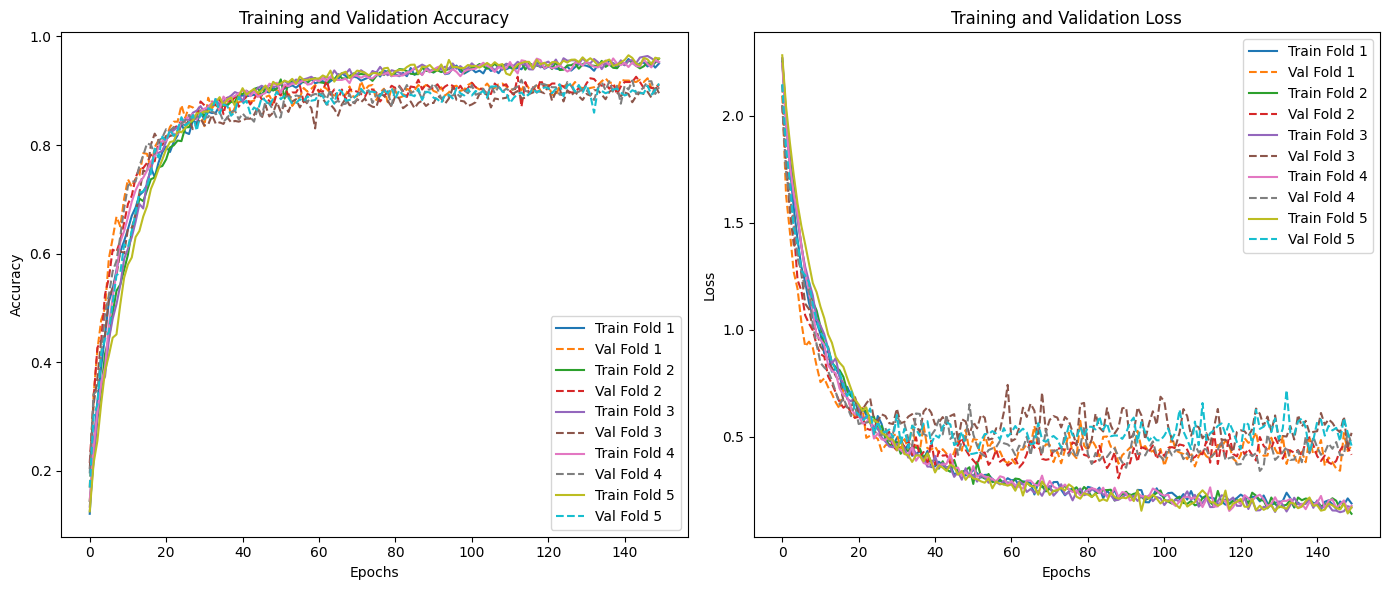

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, AveragePooling1D, Dropout, Dense, GRU, PReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam

# Configuration
NUM_FOLDS = 5
EPOCHS = 150
BATCH_SIZE = 16
RANDOM_STATE = 42
LEARNING_RATE = 0.001
INPUT_SHAPE = (32, 128)

# Encode labels
label_encoder = LabelEncoder()
integer_labels = label_encoder.fit_transform(labels)
encoded_labels = tf.one_hot(integer_labels, depth=len(label_encoder.classes_)).numpy()
NUM_CLASSES = encoded_labels.shape[1]

# Stratified K-Fold
skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Store accuracy scores and histories
fold_accuracies = []
histories = []

for fold, (train_idx, val_idx) in enumerate(skf.split(features, integer_labels)):
    print(f"\n🔁 Fold {fold+1}/{NUM_FOLDS}")

    X_train, X_val = features[train_idx], features[val_idx]
    y_train, y_val = encoded_labels[train_idx], encoded_labels[val_idx]

    # Build model
    initializer = tf.keras.initializers.GlorotUniform(seed=42)
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation=LeakyReLU(alpha=0.02),
                     kernel_initializer=initializer, padding='same', input_shape=INPUT_SHAPE))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(64, kernel_size=5, activation=LeakyReLU(alpha=0.02),
                     kernel_initializer=initializer, padding='same'))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(64, kernel_size=5, activation=LeakyReLU(alpha=0.02),
                     kernel_initializer=initializer, padding='same'))
    model.add(AveragePooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(GRU(128, return_sequences=True, kernel_initializer=initializer))
    model.add(PReLU())
    model.add(Dropout(0.3))

    model.add(GRU(128, kernel_initializer=initializer))
    model.add(PReLU())
    model.add(Dropout(0.3))

    model.add(Dense(32, kernel_initializer=initializer))
    model.add(PReLU())
    model.add(Dropout(0.3))

    model.add(Dense(32, kernel_initializer=initializer))
    model.add(PReLU())
    model.add(Dropout(0.3))

    model.add(Dense(NUM_CLASSES, activation='softmax', kernel_initializer=initializer))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=LEARNING_RATE), metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
    
    histories.append(history.history)

    # Evaluate
    y_pred = model.predict(X_val)
    acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
    fold_accuracies.append(acc)
    print(f"✅ Fold {fold+1} Accuracy: {acc:.4f}")

# Final summary
print("\n📊 Fold Accuracies:")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"\n🔚 Average Accuracy across {NUM_FOLDS} folds: {np.mean(fold_accuracies):.4f}")

# 🔥 Plot training and validation accuracy/loss
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(epochs_range, hist['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(epochs_range, hist['val_accuracy'], linestyle='--', label=f'Val Fold {i+1}')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(epochs_range, hist['loss'], label=f'Train Fold {i+1}')
    plt.plot(epochs_range, hist['val_loss'], linestyle='--', label=f'Val Fold {i+1}')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



📊 Fold Accuracies:
Fold 1: 0.9118
Fold 2: 0.9105
Fold 3: 0.8953
Fold 4: 0.9063
Fold 5: 0.9132

🔚 Average Accuracy across 5 folds: 0.9074


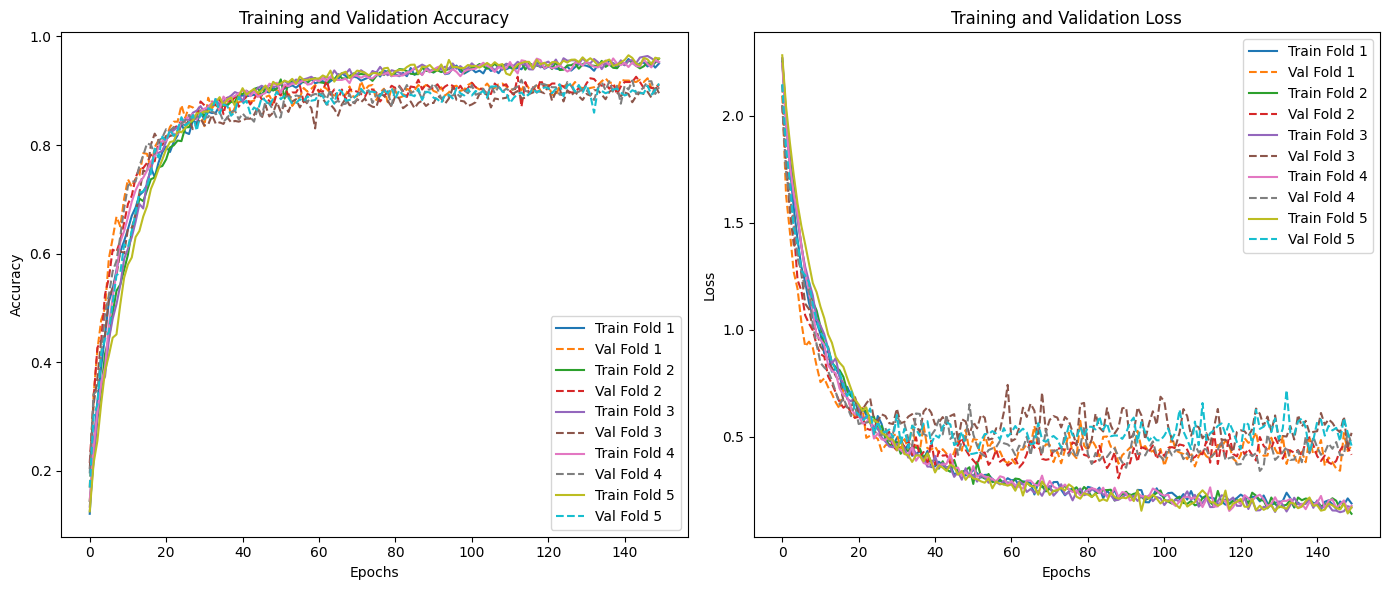

In [4]:
# Final summary
print("\n📊 Fold Accuracies:")
for i, acc in enumerate(fold_accuracies):
    print(f"Fold {i+1}: {acc:.4f}")
print(f"\n🔚 Average Accuracy across {NUM_FOLDS} folds: {np.mean(fold_accuracies):.4f}")

# 🔥 Plot training and validation accuracy/loss
epochs_range = range(EPOCHS)

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
for i, hist in enumerate(histories):
    plt.plot(epochs_range, hist['accuracy'], label=f'Train Fold {i+1}')
    plt.plot(epochs_range, hist['val_accuracy'], linestyle='--', label=f'Val Fold {i+1}')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
for i, hist in enumerate(histories):
    plt.plot(epochs_range, hist['loss'], label=f'Train Fold {i+1}')
    plt.plot(epochs_range, hist['val_loss'], linestyle='--', label=f'Val Fold {i+1}')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


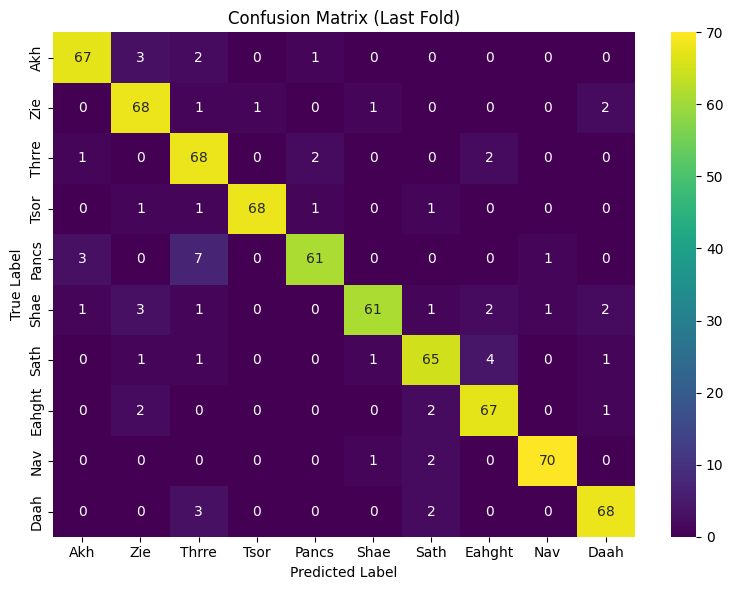

In [5]:
# 🧾 Compute and Plot Confusion Matrix for last fold
y_val_true = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_val_true, y_val_pred)

# Label ticks
custom_ticks = ['Akh', 'Zie', 'Thrre', 'Tsor', 'Pancs', "Shae", "Sath", "Eahght", "Nav", "Daah"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis',
            xticklabels=custom_ticks, yticklabels=custom_ticks)
plt.title('Confusion Matrix (Last Fold)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
